In [ ]:
import kagglehub
import seaborn as sns
import matplotlib.pyplot as plt
# Download latest version
path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/microsoft-azure-predictive-maintenance


In [ ]:
import os
import pandas as pd

# 1. Point to the mounted Kaggle input directory
BASE_PATH = "/kaggle/input/microsoft-azure-predictive-maintenance"

# 2. (Optional) See what files are available
print("Files in dataset folder:")
for fname in os.listdir(BASE_PATH):
    print(" ", fname)

# 3. Load each CSV into its own DataFrame
telemetry   = pd.read_csv(os.path.join(BASE_PATH, "PdM_telemetry.csv"))
errors      = pd.read_csv(os.path.join(BASE_PATH, "PdM_errors.csv"))
maintenance = pd.read_csv(os.path.join(BASE_PATH, "PdM_maint.csv"))
failures    = pd.read_csv(os.path.join(BASE_PATH, "PdM_failures.csv"))
machines    = pd.read_csv(os.path.join(BASE_PATH, "PdM_machines.csv"))

# 4. Quick sanity checks
print("\nData shapes:")
print(" telemetry  :", telemetry.shape)
print(" errors     :", errors.shape)
print(" maintenance:", maintenance.shape)
print(" failures   :", failures.shape)
print(" machines   :", machines.shape)

# 5. Peek at the first few rows
print("\nTelemetry head:")
display(telemetry.head())
import os
import pandas as pd

# 1. Point to the mounted Kaggle input directory
BASE_PATH = "/kaggle/input/microsoft-azure-predictive-maintenance"

# 2. (Optional) See what files are available
print("Files in dataset folder:")
for fname in os.listdir(BASE_PATH):
    print(" ", fname)

# 3. Load each CSV into its own DataFrame
telemetry   = pd.read_csv(os.path.join(BASE_PATH, "PdM_telemetry.csv"))
errors      = pd.read_csv(os.path.join(BASE_PATH, "PdM_errors.csv"))
maintenance = pd.read_csv(os.path.join(BASE_PATH, "PdM_maint.csv"))
failures    = pd.read_csv(os.path.join(BASE_PATH, "PdM_failures.csv"))
machines    = pd.read_csv(os.path.join(BASE_PATH, "PdM_machines.csv"))

# 4. Quick sanity checks
print("\nData shapes:")
print(" telemetry  :", telemetry.shape)
print(" errors     :", errors.shape)
print(" maintenance:", maintenance.shape)
print(" failures   :", failures.shape)
print(" machines   :", machines.shape)

# 5. Peek at the first few rows
print("\nTelemetry head:")
display(telemetry.head())


Files in dataset folder:
  PdM_errors.csv
  PdM_telemetry.csv
  PdM_failures.csv
  PdM_machines.csv
  PdM_maint.csv

Data shapes:
 telemetry  : (876100, 6)
 errors     : (3919, 3)
 maintenance: (3286, 3)
 failures   : (761, 3)
 machines   : (100, 3)

Telemetry head:


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
import os
import numpy as np
import pandas as pd

# ---------------------------
# Config
# ---------------------------
OUTPUT_PATH = "/content/processed_data.csv"
# ---------------------------
# Utilities
# ---------------------------
def asof_by_group(
    left: pd.DataFrame,
    right: pd.DataFrame,
    group_col: str,
    left_on: str,
    right_on: str,
    direction: str = "backward",
    allow_exact_matches: bool = True,
) -> pd.DataFrame:
    """
    Robust group-wise asof merge:
      • Coerces datetimes; drops rows with NA group/time keys.
      • Uses nullable Int64 for group ids (no IntCastingNaNError).
      • Stable sorts within each group (mergesort).
      • Drops group_col from RIGHT to avoid machineID_x/_y clashes.
      • Uses suffixes=("", "_r") for any overlapping non-key columns.
    """
    left  = left.copy()
    right = right.copy()

    # Datetime coercion and NA filtering on keys
    left[left_on]   = pd.to_datetime(left[left_on],   utc=False, errors="coerce")
    right[right_on] = pd.to_datetime(right[right_on], utc=False, errors="coerce")

    if group_col in left:
        left[group_col] = pd.to_numeric(left[group_col], errors="coerce").astype("Int64")
        left = left[left[group_col].notna() & left[left_on].notna()]
    if group_col in right:
        right[group_col] = pd.to_numeric(right[group_col], errors="coerce").astype("Int64")
        right = right[right[group_col].notna() & right[right_on].notna()]

    out = []
    # iterate over groups present in LEFT (keeps left rows even if RIGHT has none)
    for gid, ldf in left.groupby(group_col, sort=False):
        rdf = right[right[group_col] == gid].copy()
        ldf = ldf.sort_values(left_on,  kind="mergesort")
        if rdf.empty:
            out.append(ldf)
            continue

        rdf = rdf.sort_values(right_on, kind="mergesort")
        # avoid duplicate group column names
        rdf.drop(columns=[group_col], inplace=True, errors="ignore")

        merged = pd.merge_asof(
            ldf, rdf,
            left_on=left_on, right_on=right_on,
            direction=direction, allow_exact_matches=allow_exact_matches,
            suffixes=("", "_r")
        )
        out.append(merged)

    return pd.concat(out, ignore_index=True)


def clean_suffix_dupes(df: pd.DataFrame) -> pd.DataFrame:
    """Tidy up any lingering *_x/*_y style columns, preferring left-side names."""
    df = df.copy()
    # Drop any _y columns if the unsuffixed version exists
    to_drop = []
    to_rename = {}
    for c in df.columns:
        if c.endswith("_y"):
            base = c[:-2]
            if base in df.columns:
                to_drop.append(c)
    df.drop(columns=to_drop, errors="ignore", inplace=True)
    # Rename *_x back to base if base not present
    for c in df.columns:
        if c.endswith("_x"):
            base = c[:-2]
            if base not in df.columns:
                to_rename[c] = base
    if to_rename:
        df.rename(columns=to_rename, inplace=True)
    return df


# ---------------------------
# Load data
# ---------------------------
telemetry = pd.read_csv(
    os.path.join(BASE_PATH, "PdM_telemetry.csv"),
    parse_dates=["datetime"]
)
errors      = pd.read_csv(os.path.join(BASE_PATH, "PdM_errors.csv"),      parse_dates=["datetime"])
failures    = pd.read_csv(os.path.join(BASE_PATH, "PdM_failures.csv"),    parse_dates=["datetime"])
maintenance = pd.read_csv(os.path.join(BASE_PATH, "PdM_maint.csv"),       parse_dates=["datetime"])
machines    = pd.read_csv(os.path.join(BASE_PATH, "PdM_machines.csv"))

# Ensure key dtypes
for df in (telemetry, failures, maintenance, machines):
    if "machineID" in df.columns:
        df["machineID"] = pd.to_numeric(df["machineID"], errors="coerce").astype("Int64")

# Rename time cols for clarity on right-hand tables
failures    = failures.rename(columns={"datetime": "failure_time"})
maintenance = maintenance.rename(columns={"datetime": "maint_time"})

# Sort telemetry stably for rolling & merges
telemetry = telemetry.sort_values(["machineID", "datetime"], kind="mergesort").reset_index(drop=True)

# ---------------------------
# Rolling features
# ---------------------------
windows = [3, 24]  # hours
sensors = ["volt", "rotate", "pressure", "vibration"]

for w in windows:
    rolled = telemetry.groupby("machineID", dropna=False)[sensors].rolling(w, min_periods=1)
    means  = rolled.mean().reset_index(level=0, drop=True)
    stds   = rolled.std().reset_index(level=0, drop=True)
    for s in sensors:
        telemetry[f"{s}_mean_{w}h"] = means[s]
        telemetry[f"{s}_std_{w}h"]  = stds[s]

# ---------------------------
# Cyclical time features
# ---------------------------
dt = telemetry["datetime"]
hour   = dt.dt.hour
dow    = dt.dt.dayofweek
month0 = dt.dt.month - 1

telemetry["hour_sin"]  = np.sin(2*np.pi * hour / 24)
telemetry["hour_cos"]  = np.cos(2*np.pi * hour / 24)
telemetry["dow_sin"]   = np.sin(2*np.pi * dow  / 7)
telemetry["dow_cos"]   = np.cos(2*np.pi * dow  / 7)
telemetry["month_sin"] = np.sin(2*np.pi * month0 / 12)
telemetry["month_cos"] = np.cos(2*np.pi * month0 / 12)

# ---------------------------
# Static machine attributes
# ---------------------------
telemetry = telemetry.merge(machines, on="machineID", how="left")
telemetry = telemetry.sort_values(["machineID", "datetime"], kind="mergesort").reset_index(drop=True)
telemetry = clean_suffix_dupes(telemetry)

# ---------------------------
# Time since last failure (backward)
# ---------------------------
telemetry = asof_by_group(
    left=telemetry,
    right=failures[["machineID", "failure_time"]],
    group_col="machineID",
    left_on="datetime",
    right_on="failure_time",
    direction="backward",
    allow_exact_matches=True,
)

telemetry["time_since_last_failure_h"] = (
    (telemetry["datetime"] - telemetry["failure_time"]).dt.total_seconds() / 3600.0
)
# Fill NA with max observed horizon (meaning "no prior failure")
max_tsf = telemetry["time_since_last_failure_h"].max()
telemetry["time_since_last_failure_h"] = telemetry["time_since_last_failure_h"].fillna(max_tsf)

# ---------------------------
# Time since last maintenance (backward)
# ---------------------------
telemetry = asof_by_group(
    left=telemetry,
    right=maintenance[["machineID", "maint_time"]],
    group_col="machineID",
    left_on="datetime",
    right_on="maint_time",
    direction="backward",
    allow_exact_matches=True,
)

telemetry["time_since_last_maint_h"] = (
    (telemetry["datetime"] - telemetry["maint_time"]).dt.total_seconds() / 3600.0
)
max_tsm = telemetry["time_since_last_maint_h"].max()
telemetry["time_since_last_maint_h"] = telemetry["time_since_last_maint_h"].fillna(max_tsm)

# ---------------------------
# Time to next failure (forward) + label
# ---------------------------
fail_forward = failures.rename(columns={"failure_time": "next_failure_time"})

telemetry = asof_by_group(
    left=telemetry,
    right=fail_forward[["machineID", "next_failure_time"]],
    group_col="machineID",
    left_on="datetime",
    right_on="next_failure_time",
    direction="forward",
    allow_exact_matches=True,
)

telemetry["time_to_next_failure_h"] = (
    (telemetry["next_failure_time"] - telemetry["datetime"]).dt.total_seconds() / 3600.0
)
telemetry["failure_in_24h"] = (telemetry["time_to_next_failure_h"] <= 24).astype("Int64").fillna(0).astype(int)

# ---------------------------
# Cleanup & save
# ---------------------------
# Drop intermediate right-side time cols and any residual *_r columns
drop_cols = [c for c in ["failure_time", "maint_time", "next_failure_time"] if c in telemetry.columns]
drop_cols += [c for c in telemetry.columns if c.endswith("_r")]
telemetry.drop(columns=drop_cols, errors="ignore", inplace=True)

# Save to CSV
telemetry.to_csv(OUTPUT_PATH, index=False)

print(f"Processed data saved to: {OUTPUT_PATH}")
print("\nProcessed telemetry head:")
display(telemetry.head())

Processed data saved to: /content/processed_data.csv

Processed telemetry head:


,datetime,machineID,volt,rotate,pressure,vibration,volt_mean_3h,volt_std_3h,rotate_mean_3h,rotate_std_3h,...,dow_sin,dow_cos,month_sin,month_cos,model,age,time_since_last_failure_h,time_since_last_maint_h,time_to_next_failure_h,failure_in_24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,176.217853,NaN,418.504078,NaN,...,0.433884,-0.900969,0.0,1.0,model3,18,7464.0,456.0,96.0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,169.548538,9.431836,410.625784,11.141591,...,0.433884,-0.900969,0.0,1.0,model3,18,7464.0,457.0,95.0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,170.028993,6.721032,449.533798,67.849599,...,0.433884,-0.900969,0.0,1.0,model3,18,7464.0,458.0,94.0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,165.443986,4.807415,425.415550,92.702671,...,0.433884,-0.900969,0.0,1.0,model3,18,7464.0,459.0,93.0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,163.687586,6.773501,436.292011,90.603712,...,0.433884,-0.900969,0.0,1.0,model3,18,7464.0,460.0,92.0,0


In [ ]:
import pandas as pd
import numpy as np

PATH = "/content/processed_data.csv"

# 1) Load
df = pd.read_csv(PATH)

# 2) Parse datetime robustly
dt = pd.to_datetime(df["datetime"], errors="coerce")

# 3) Drop rows with invalid/missing datetime or missing machineID (prevents None group keys later)
valid_mask = dt.notna() & df["machineID"].notna()
df = df.loc[valid_mask].copy()
dt = dt.loc[valid_mask]

# 4) Date & time columns (as strings)
df["date"] = dt.dt.strftime("%Y-%m-%d")          # e.g., 2015-01-01
df["time"] = dt.dt.strftime("%H:%M:%S")          # e.g., 06:00:00

# 5) Extra datetime features (useful for models)
iso = dt.dt.isocalendar()                         # pandas >= 1.1
df["year"]        = dt.dt.year.astype("int32")
df["quarter"]     = dt.dt.quarter.astype("int32")
df["month"]       = dt.dt.month.astype("int32")
df["day"]         = dt.dt.day.astype("int32")
df["dayofyear"]   = dt.dt.dayofyear.astype("int32")
df["weekofyear"]  = iso.week.astype("Int64")     # ISO week (nullable Int)
df["dayofweek"]   = dt.dt.dayofweek.astype("int32")  # 0=Mon, 6=Sun
df["day_name"]    = dt.dt.day_name()
df["hour"]        = dt.dt.hour.astype("int32")
df["minute"]      = dt.dt.minute.astype("int32")
df["second"]      = dt.dt.second.astype("int32")
df["is_weekend"]  = df["dayofweek"].isin([5, 6]).astype("Int64")

# 6) Drop the original 'datetime' now that features are created
if "datetime" in df.columns:
    df = df.drop(columns=["datetime"])

# 7) Reorder: put new columns after 'machineID'
new_cols = ["date", "time", "year", "quarter", "month", "day", "dayofyear",
            "weekofyear", "dayofweek", "day_name", "hour", "minute", "second", "is_weekend"]

if "machineID" in df.columns:
    cols = list(df.columns)
    # remove if already present (idempotent re-runs)
    for c in new_cols:
        if c in cols:
            cols.remove(c)
    pos = list(df.columns).index("machineID") + 1
    for i, c in enumerate(new_cols):
        cols.insert(pos + i, c)
    df = df[cols]

# 8) Ensure machineID is plain int (now that bad rows were removed)
if df["machineID"].isna().sum() == 0:
    df["machineID"] = df["machineID"].astype(int)

# 9) Save
df.to_csv(PATH, index=False)
print(f"Processed data saved to: {PATH}")
print("Final shape:", df.shape)


Processed data saved to: /content/processed_data.csv
Final shape: (876100, 47)


In [ ]:
print(df.shape)
df.info(memory_usage="deep")
df.describe().T


(876100, 47)
<class 'pandas.core.frame.DataFrame'>
Index: 876100 entries, 0 to 876099
Data columns (total 47 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   machineID                  876100 non-null  int64  
 1   date                       876100 non-null  object 
 2   time                       876100 non-null  object 
 3   year                       876100 non-null  int32  
 4   quarter                    876100 non-null  int32  
 5   month                      876100 non-null  int32  
 6   day                        876100 non-null  int32  
 7   dayofyear                  876100 non-null  int32  
 8   weekofyear                 876100 non-null  Int64  
 9   dayofweek                  876100 non-null  int32  
 10  day_name                   876100 non-null  object 
 11  hour                       876100 non-null  int32  
 12  minute                     876100 non-null  int32  
 13  second               

,count,mean,std,min,25%,50%,75%,max
machineID,876100.0,50.5,28.866087,1.0,25.75,50.5,75.25,100.0
year,876100.0,2015.000799,0.028255,2015.0,2015.0,2015.0,2015.0,2016.0
quarter,876100.0,2.509417,1.11682,1.0,2.0,3.0,4.0,4.0
month,876100.0,6.525397,3.448162,1.0,4.0,7.0,10.0,12.0
day,876100.0,15.718868,8.797156,1.0,8.0,16.0,23.0,31.0
dayofyear,876100.0,182.979226,105.378014,1.0,92.0,183.0,274.0,365.0
weekofyear,876100.0,27.03858,15.059359,1.0,14.0,27.0,40.0,53.0
dayofweek,876100.0,3.000799,1.997345,0.0,1.0,3.0,5.0,6.0
hour,876100.0,11.499372,6.922045,0.0,6.0,11.0,17.0,23.0
minute,876100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='failure_in_24h', ylabel='count'>

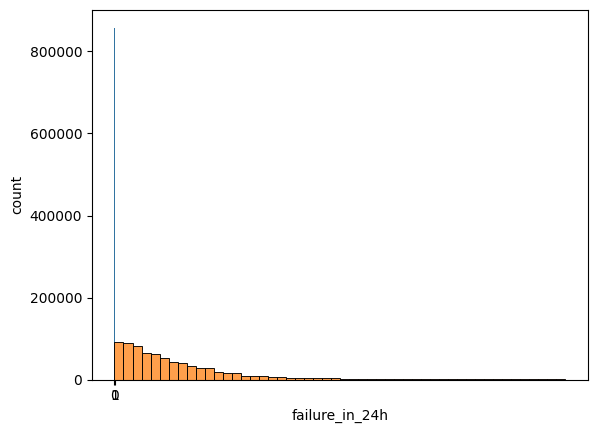

In [ ]:
sns.countplot(x="failure_in_24h", data=df)
sns.histplot(df["time_to_next_failure_h"], bins=50)


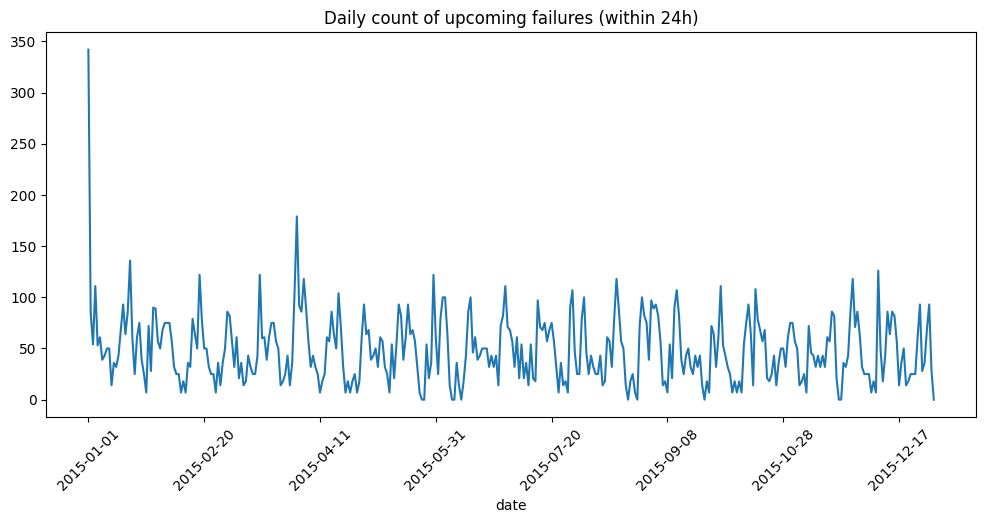

In [ ]:
plt.figure(figsize=(12,5))
df.groupby("date")["failure_in_24h"].sum().plot()
plt.title("Daily count of upcoming failures (within 24h)")
plt.xticks(rotation=45)
plt.show()


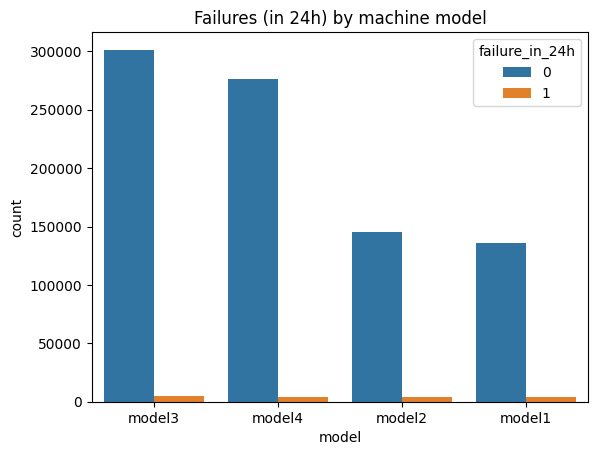

In [ ]:
sns.countplot(x="model", hue="failure_in_24h", data=df)
plt.title("Failures (in 24h) by machine model")
plt.show()


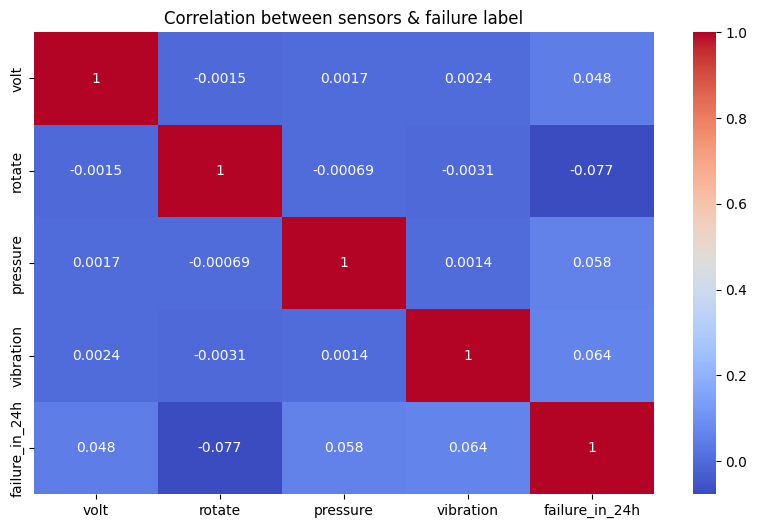

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df[["volt","rotate","pressure","vibration","failure_in_24h"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation between sensors & failure label")
plt.show()


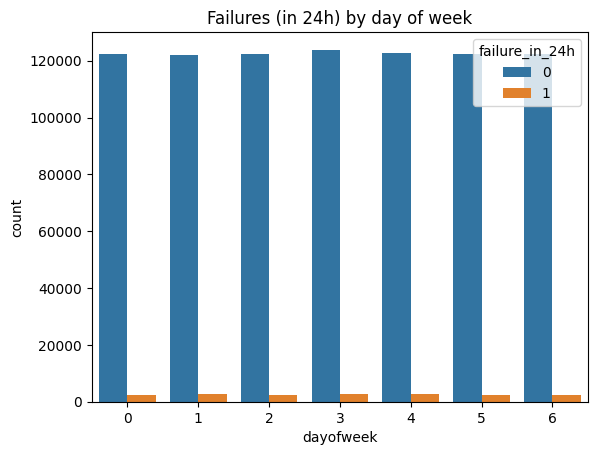

In [ ]:
sns.countplot(x="dayofweek", hue="failure_in_24h", data=df)
plt.title("Failures (in 24h) by day of week")
plt.show()


In [ ]:
# Part 1 — imports, config, fast load
import time
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, r2_score

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.decomposition import PCA

# ---------------- CFG ----------------
TARGET_COL   = "failure_in_24h"          # or "time_to_next_failure_h"
IN_PATH      = "/content/processed_data.csv"
OUT_DIR      = Path("/content")
TOPK         = 30
RANDOM_STATE = 42

# columns to always drop from feature candidates
DROP_ALWAYS = {"window_end", "failure_in_24h", "time_to_next_failure_h"}
ID_LIKE     = {"machineID"}              # IDs kept for join, excluded from X

# -------------- LOAD --------------
t0 = time.time()
df = pd.read_csv(IN_PATH)
print(f"Loaded {IN_PATH} → shape={df.shape} in {time.time()-t0:.2f}s")

# Basic sanity checks
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL='{TARGET_COL}' not found in columns")

# Decide task type and prep y
if TARGET_COL == "failure_in_24h":
    TASK = "classification"
    y = df[TARGET_COL].astype("int8")
    drop_labels = DROP_ALWAYS - {"failure_in_24h"}
else:
    TASK = "regression"
    df = df[df[TARGET_COL].notna()].copy()
    y = df[TARGET_COL].astype("float32")
    drop_labels = DROP_ALWAYS - {"time_to_next_failure_h"}

# Build candidate feature list (numeric only, drop target/IDs/leaks)
num_cols    = df.select_dtypes(include=["number"]).columns.tolist()
exclude_set = set([TARGET_COL]) | drop_labels | ID_LIKE
feature_cols = [c for c in num_cols if c not in exclude_set]

if len(feature_cols) < TOPK:
    TOPK = len(feature_cols)

print(f"Candidate numeric features: {len(feature_cols)}")


Loaded /content/processed_data.csv → shape=(876100, 47) in 11.32s
Candidate numeric features: 40


In [ ]:
# Part 2 — build X fast and split
# Use float32 to cut memory and speed up many ops a bit
X = df[feature_cols].astype("float32", copy=False)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y if TASK == "classification" else None,
)

# Fit a single imputer once; reuse for MI and linear model
imputer = SimpleImputer(strategy="median")
Xtr_imp = imputer.fit_transform(X_train)
Xva_imp = imputer.transform(X_val)

print("Train/val shapes:", X_train.shape, X_val.shape)


Train/val shapes: (700880, 40) (175220, 40)


In [ ]:
# ---------- feature selection (fast MI) ----------
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.decomposition import PCA

def select_top_features(
    df: pd.DataFrame,
    target_col: str = "failure_in_24h",
    topk: int = 30,
    id_like = ("machineID",),
    drop_always = ("window_end", "failure_in_24h", "time_to_next_failure_h"),
    test_size: float = 0.2,
    random_state: int = 42,
    fast_mi: bool = True,
    mi_subsample: int = 2,        # e.g. use every 2nd row for MI
    pca_report: bool = True,
    out_dir: str | Path = "/content"
):
    """
    Returns (top_features, scores_df, df_reduced)
    - top_features: list[str] of top-k feature names
    - scores_df: DataFrame with MI / Tree / L1 scores + aggregate
    - df_reduced: original df reduced to id + target + top features
    """
    out_dir = Path(out_dir)
    assert target_col in df.columns, f"{target_col=} missing"

    # Decide task
    if target_col == "failure_in_24h":
        task = "classification"
        y = df[target_col].astype("int8")
        drop_labels = set(drop_always) - {"failure_in_24h"}
    else:
        task = "regression"
        df = df[df[target_col].notna()].copy()
        y = df[target_col].astype("float32")
        drop_labels = set(drop_always) - {"time_to_next_failure_h"}

    # Candidate numeric features
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    exclude = set([target_col]) | drop_labels | set(id_like)
    feature_cols = [c for c in num_cols if c not in exclude]
    if len(feature_cols) == 0:
        raise ValueError("No numeric candidate features found.")

    if topk > len(feature_cols):
        topk = len(feature_cols)

    X = df[feature_cols].astype("float32", copy=False)

    # Split
    Xtr, Xva, ytr, yva = train_test_split(
        X, y, test_size=test_size, random_state=random_state,
        stratify=y if task == "classification" else None
    )

    # Single imputer reused
    imp = SimpleImputer(strategy="median")
    Xtr_imp = imp.fit_transform(Xtr)
    Xva_imp = imp.transform(Xva)

    scores_parts = {}

    # -------- 1) Mutual Information (optionally subsampled) --------
    if fast_mi and Xtr_imp.shape[0] > 2 * mi_subsample:
        Xmi = Xtr_imp[::mi_subsample]
        ymi = ytr.iloc[::mi_subsample] if hasattr(ytr, "iloc") else ytr[::mi_subsample]
    else:
        Xmi = Xtr_imp
        ymi = ytr

    if task == "classification":
        mi = mutual_info_classif(Xmi, ymi, random_state=random_state, discrete_features=False)
    else:
        mi = mutual_info_regression(Xmi, ymi, random_state=random_state)
    scores_parts["mutual_info"] = pd.Series(mi, index=feature_cols)

    # -------- 2) ExtraTrees importance --------
    if task == "classification":
        tree = ExtraTreesClassifier(
            n_estimators=400, random_state=random_state,
            n_jobs=-1, class_weight="balanced_subsample"
        )
    else:
        tree = ExtraTreesRegressor(
            n_estimators=400, random_state=random_state, n_jobs=-1
        )
    tree.fit(Xtr_imp, ytr)
    if task == "classification":
        auc = roc_auc_score(yva, tree.predict_proba(Xva_imp)[:, 1])
        print(f"[ExtraTrees] ROC-AUC={auc:.4f}")
    else:
        r2 = r2_score(yva, tree.predict(Xva_imp))
        print(f"[ExtraTrees] R^2={r2:.4f}")
    scores_parts["tree_importance"] = pd.Series(tree.feature_importances_, index=feature_cols)

    # -------- 3) L1 linear model --------
    scaler = StandardScaler(with_mean=True, with_std=True)
    Xtr_std = scaler.fit_transform(Xtr_imp)
    Xva_std = scaler.transform(Xva_imp)

    if task == "classification":
        lin = LogisticRegression(
            penalty="l1", solver="saga", max_iter=4000,
            C=1.0, random_state=random_state, n_jobs=-1
        )
        lin.fit(Xtr_std, ytr)
        coef = np.abs(lin.coef_.ravel())
    else:
        lin = Lasso(alpha=1e-3, max_iter=8000, random_state=random_state)
        lin.fit(Xtr_std, ytr)
        coef = np.abs(lin.coef_.ravel())

    scores_parts["linear_abs_coef"] = pd.Series(coef, index=feature_cols)

    # -------- Combine & rank --------
    def _norm(s: pd.Series) -> pd.Series:
        s = s.fillna(0.0)
        rng = float(s.max() - s.min())
        return (s - s.min()) / (rng + 1e-12)

    scores_df = pd.concat(
        [_norm(scores_parts["mutual_info"]),
         _norm(scores_parts["tree_importance"]),
         _norm(scores_parts["linear_abs_coef"])],
        axis=1
    )
    scores_df.columns = ["mutual_info", "tree_importance", "linear_abs_coef"]
    scores_df["agg_score"] = scores_df.mean(axis=1)
    scores_df = scores_df.sort_values("agg_score", ascending=False)

    top_features = scores_df.head(topk).index.tolist()
    print(f"Top {topk} features picked.")

    # Optional PCA report
    if pca_report:
        pca = PCA(n_components=min(10, Xtr.shape[1]), random_state=random_state)
        pca.fit(Xtr_std)
        print("[PCA] First components:", np.round(pca.explained_variance_ratio_, 4))
        print("[PCA] Cumulative:", np.round(np.cumsum(pca.explained_variance_ratio_), 4))

    # Build reduced dataset to save/use
    keep_cols = ([c for c in id_like if c in df.columns] +
                 [target_col] + top_features)
    df_reduced = df[keep_cols].copy()

    # Save artifacts
    out_dir.mkdir(parents=True, exist_ok=True)
    pd.Series(top_features, name="top_features").to_csv(out_dir / "top_features.csv", index=False)
    scores_df.to_csv(out_dir / "all_feature_scores.csv", index=True)
    df_reduced.to_csv(out_dir / "dataset_topk.csv", index=False)

    return top_features, scores_df, df_reduced


In [ ]:
# ---------- Part B: training + metrics ----------
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, roc_auc_score, average_precision_score,
    confusion_matrix, jaccard_score, mean_absolute_error, mean_squared_error
)
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor

def train_predictive_model(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: list[str],
    id_like = ("machineID",),
    random_state: int = 42,
    test_size: float = 0.2
):
    """
    Trains a model for:
      - classification (failure_in_24h)  OR
      - regression (time_to_next_failure_h)
    Returns: model, metrics (dict), X_val, y_val, y_pred_proba/pred
    """
    assert target_col in df.columns
    for f in feature_cols:
        assert f in df.columns, f"Feature {f} missing."

    # Build X, y
    X = df[feature_cols].astype("float32", copy=False)
    y = df[target_col].copy()

    # Split
    strat = y if target_col == "failure_in_24h" else None
    Xtr, Xva, ytr, yva = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    # Impute (tree models handle unscaled features well)
    imp = SimpleImputer(strategy="median")
    Xtr_imp = imp.fit_transform(Xtr)
    Xva_imp = imp.transform(Xva)

    metrics = {}

    if target_col == "failure_in_24h":
        # ---- Binary classification ----
        clf = HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_depth=None,
            max_iter=300,
            l2_regularization=0.0,
            random_state=random_state
        )
        clf.fit(Xtr_imp, ytr)

        # probabilities and default-threshold preds
        proba = clf.predict_proba(Xva_imp)[:, 1]
        pred05 = (proba >= 0.5).astype(int)

        # threshold sweep to maximize F1
        thresholds = np.linspace(0.05, 0.95, 19)
        f1_scores = []
        for th in thresholds:
            f1_scores.append(f1_score(yva, (proba >= th).astype(int)))
        best_idx = int(np.argmax(f1_scores))
        best_th = float(thresholds[best_idx])
        pred_best = (proba >= best_th).astype(int)

        # metrics @ default 0.5
        metrics["accuracy@0.5"] = accuracy_score(yva, pred05)
        metrics["log_loss"]     = log_loss(yva, proba, labels=[0,1])
        metrics["iou@0.5"]      = jaccard_score(yva, pred05)  # IoU/Jaccard = TP/(TP+FP+FN)
        metrics["precision@0.5"]= precision_score(yva, pred05, zero_division=0)
        metrics["recall@0.5"]   = recall_score(yva, pred05, zero_division=0)
        metrics["f1@0.5"]       = f1_score(yva, pred05, zero_division=0)
        metrics["roc_auc"]      = roc_auc_score(yva, proba)
        metrics["pr_auc"]       = average_precision_score(yva, proba)
        metrics["cm@0.5"]       = confusion_matrix(yva, pred05).tolist()

        # metrics @ best F1 threshold
        metrics["best_threshold"] = best_th
        metrics["accuracy@best"]  = accuracy_score(yva, pred_best)
        metrics["iou@best"]       = jaccard_score(yva, pred_best)
        metrics["precision@best"] = precision_score(yva, pred_best, zero_division=0)
        metrics["recall@best"]    = recall_score(yva, pred_best, zero_division=0)
        metrics["f1@best"]        = f1_score(yva, pred_best, zero_division=0)
        metrics["cm@best"]        = confusion_matrix(yva, pred_best).tolist()

        return clf, metrics, (Xva_imp, yva, proba)

    else:
        # ---- Regression for time_to_next_failure_h ----
        reg = HistGradientBoostingRegressor(
            learning_rate=0.1,
            max_depth=None,
            max_iter=400,
            l2_regularization=0.0,
            random_state=random_state
        )
        reg.fit(Xtr_imp, ytr)
        pred = reg.predict(Xva_imp)
        metrics["MAE"] = mean_absolute_error(yva, pred)
        metrics["RMSE"] = float(np.sqrt(mean_squared_error(yva, pred)))
        metrics["R2"] = r2_score(yva, pred)
        return reg, metrics, (Xva_imp, yva, pred)


/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
# 1) pick top features quickly (with MI subsampling)
top_features, score_table, df_reduced = select_top_features(
    df=pd.read_csv("/content/processed_data.csv"),
    target_col="failure_in_24h",   # or "time_to_next_failure_h"
    topk=30,
    fast_mi=True,
    mi_subsample=2,                # every 2nd row for MI
    pca_report=True,
    out_dir="/content"
)


# 2) train and evaluate the model with full metrics (incl. IoU / Jaccard)
model, metrics, (X_val, y_val, pred_probs_or_pred) = train_predictive_model(
    df=df_reduced,                 # use the reduced dataset
    target_col="failure_in_24h",   # or "time_to_next_failure_h"
    feature_cols=top_features
)

print("\nMetrics:")
for k, v in metrics.items():
    print(f"{k:>14}: {v}")


[ExtraTrees] ROC-AUC=0.9998
Top 30 features picked.
[PCA] First components: [0.1253 0.067  0.0578 0.0552 0.0529 0.0511 0.047  0.04   0.0335 0.0333]
[PCA] Cumulative: [0.1253 0.1923 0.25   0.3052 0.3581 0.4091 0.4561 0.4961 0.5296 0.5629]

Metrics:
  accuracy@0.5: 0.9976087204657003
      log_loss: 0.011455538415870655
       iou@0.5: 0.8916192446973616
 precision@0.5: 0.9233860166086257
    recall@0.5: 0.9628491620111732
        f1@0.5: 0.94270477232326
       roc_auc: 0.9990760787486865
        pr_auc: 0.9568659189973387
        cm@0.5: [[171354, 286], [133, 3447]]
best_threshold: 0.6
 accuracy@best: 0.9977742266864513
      iou@best: 0.8962765957446809
precision@best: 0.9492957746478873
   recall@best: 0.9413407821229051
       f1@best: 0.9453015427769986
       cm@best: [[171460, 180], [210, 3370]]


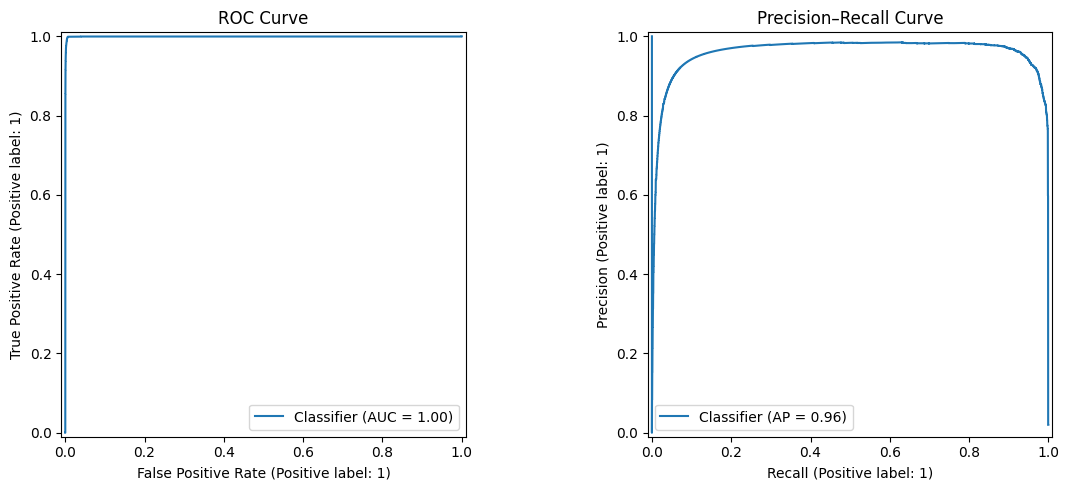

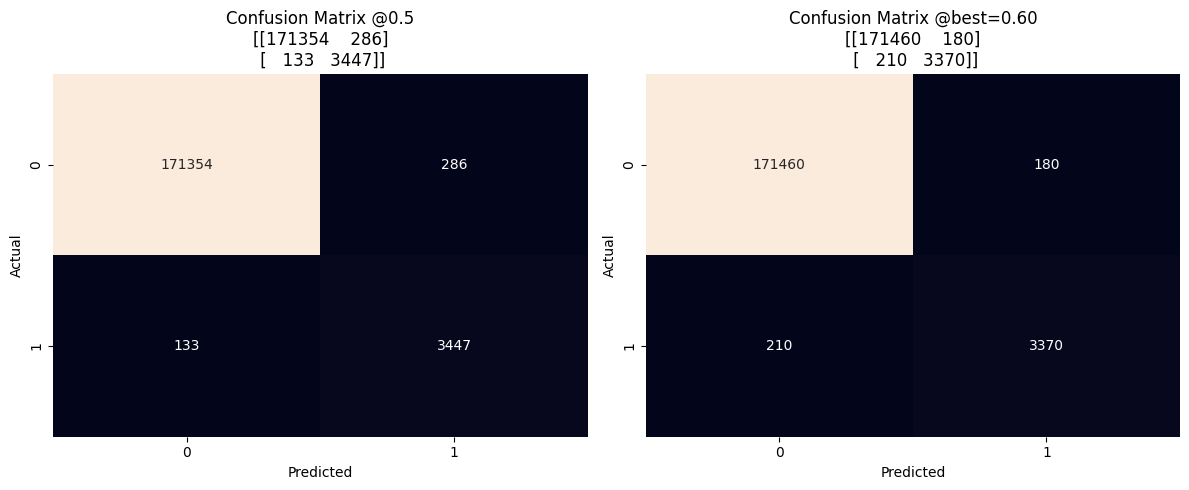

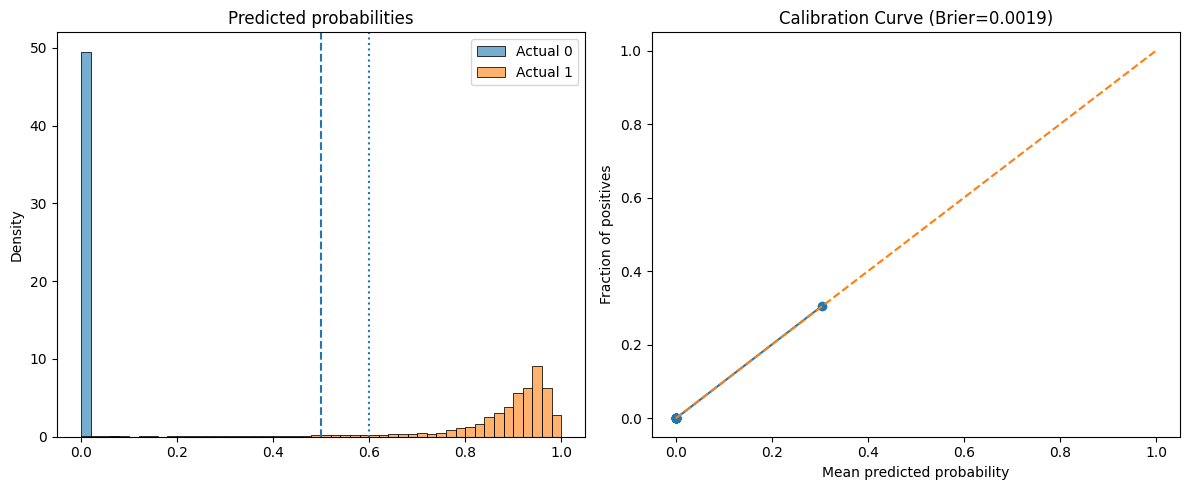

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 94.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/tmp/ipython-input-608379477.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Actual 0","Actual 1"])
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:3399: UserWarning: 95.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


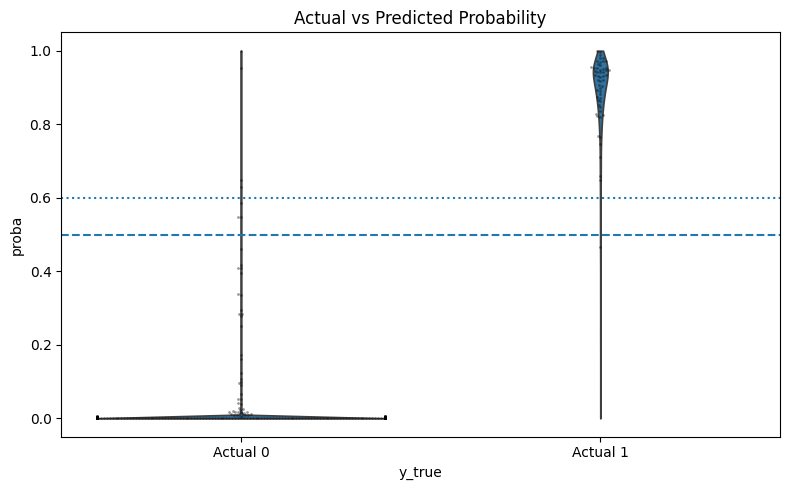

In [ ]:
# === A) Evaluate current model (classification) ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    confusion_matrix, precision_recall_curve, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve

# unpack things from your earlier step
proba = pred_probs_or_pred  # for classification we got probabilities
y_true = y_val

# pick thresholds
th_default = 0.5
th_best = metrics.get("best_threshold", 0.5)

y_pred_05   = (proba >= th_default).astype(int)
y_pred_best = (proba >= th_best).astype(int)

# --- 1) ROC & PR ---
fig, ax = plt.subplots(1, 2, figsize=(12,5))
RocCurveDisplay.from_predictions(y_true, proba, ax=ax[0])
ax[0].set_title("ROC Curve")

PrecisionRecallDisplay.from_predictions(y_true, proba, ax=ax[1])
ax[1].set_title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

# --- 2) Confusion matrices ---
cm_05   = confusion_matrix(y_true, y_pred_05)
cm_best = confusion_matrix(y_true, y_pred_best)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_05, annot=True, fmt="d", cbar=False, ax=ax[0])
ax[0].set_title(f"Confusion Matrix @0.5\n{cm_05}")
ax[0].set_xlabel("Predicted"); ax[0].set_ylabel("Actual")

sns.heatmap(cm_best, annot=True, fmt="d", cbar=False, ax=ax[1])
ax[1].set_title(f"Confusion Matrix @best={th_best:.2f}\n{cm_best}")
ax[1].set_xlabel("Predicted"); ax[1].set_ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 3) Probability distributions by class ---
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(proba[y_true==0], bins=50, stat="density", alpha=0.6, label="Actual 0", ax=ax[0])
sns.histplot(proba[y_true==1], bins=50, stat="density", alpha=0.6, label="Actual 1", ax=ax[0])
ax[0].axvline(th_default, ls="--"); ax[0].axvline(th_best, ls=":")
ax[0].legend(); ax[0].set_title("Predicted probabilities")

# --- 4) Calibration (reliability) ---
prob_true, prob_pred = calibration_curve(y_true, proba, n_bins=15, strategy="quantile")
ax[1].plot(prob_pred, prob_true, marker="o")
ax[1].plot([0,1],[0,1], ls="--")
ax[1].set_title(f"Calibration Curve (Brier={brier_score_loss(y_true, proba):.4f})")
ax[1].set_xlabel("Mean predicted probability")
ax[1].set_ylabel("Fraction of positives")
plt.tight_layout()
plt.show()

# --- 5) Actual vs Predicted plot (violin + swarm) ---
plot_df = pd.DataFrame({"y_true": y_true.astype(int), "proba": proba})
fig, ax = plt.subplots(figsize=(8,5))
sns.violinplot(data=plot_df, x="y_true", y="proba", inner=None, ax=ax, cut=0)
sns.swarmplot(data=plot_df.sample(min(3000, len(plot_df)), random_state=0),
              x="y_true", y="proba", color="k", size=2, alpha=0.4, ax=ax)
ax.set_xticklabels(["Actual 0","Actual 1"])
ax.set_title("Actual vs Predicted Probability")
ax.axhline(th_default, ls="--"); ax.axhline(th_best, ls=":")
plt.tight_layout()
plt.show()


In [ ]:
# === B) explicit train/val/test and re-train for a true holdout ===
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_hist_gradient_boosting  # noqa: F401
from sklearn.ensemble import HistGradientBoostingClassifier

# Use the same reduced dataset & top_features
df_use = df_reduced.copy()

# Split train+val vs test
df_trv, df_te = train_test_split(
    df_use, test_size=0.2, random_state=42,
    stratify=df_use["failure_in_24h"]
)

X_trv = df_trv[top_features].astype("float32")
y_trv = df_trv["failure_in_24h"].astype(int)
X_te  = df_te[top_features].astype("float32")
y_te  = df_te["failure_in_24h"].astype(int)

# Inside train, split train/val again
X_tr, X_va, y_tr, y_va = train_test_split(
    X_trv, y_trv, test_size=0.2, random_state=42, stratify=y_trv
)

imp = SimpleImputer(strategy="median")
X_tr_i = imp.fit_transform(X_tr)
X_va_i = imp.transform(X_va)
X_te_i = imp.transform(X_te)

clf = HistGradientBoostingClassifier(
    learning_rate=0.1, max_depth=None, max_iter=300,
    l2_regularization=0.0, random_state=42
)
clf.fit(X_tr_i, y_tr)

# Choose threshold by best F1 on validation
from sklearn.metrics import f1_score
proba_va = clf.predict_proba(X_va_i)[:,1]
ths = np.linspace(0.05, 0.95, 19)
best_th = ths[np.argmax([f1_score(y_va, (proba_va>=t).astype(int)) for t in ths])]

# Evaluate on TEST
proba_te = clf.predict_proba(X_te_i)[:,1]
y_pred_05   = (proba_te >= 0.5).astype(int)
y_pred_best = (proba_te >= best_th).astype(int)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, jaccard_score,
    log_loss, roc_auc_score, average_precision_score, confusion_matrix
)
print("\n=== TEST metrics ===")
print("accuracy@0.5:", accuracy_score(y_te, y_pred_05))
print("   log_loss :", log_loss(y_te, proba_te))
print("    iou@0.5:", jaccard_score(y_te, y_pred_05))
print("precision@0.5:", precision_score(y_te, y_pred_05, zero_division=0))
print("   recall@0.5:", recall_score(y_te, y_pred_05, zero_division=0))
print("       f1@0.5:", f1_score(y_te, y_pred_05, zero_division=0))
print("      roc_auc:", roc_auc_score(y_te, proba_te))
print("       pr_auc:", average_precision_score(y_te, proba_te))
print("     cm@0.5 :", confusion_matrix(y_te, y_pred_05).tolist())

print(f"\nBest threshold from VAL: {best_th:.2f}")
print("accuracy@best:", accuracy_score(y_te, y_pred_best))
print("   iou@best :", jaccard_score(y_te, y_pred_best))
print("precision@best:", precision_score(y_te, y_pred_best, zero_division=0))
print("   recall@best:", recall_score(y_te, y_pred_best, zero_division=0))
print("       f1@best:", f1_score(y_te, y_pred_best, zero_division=0))
print("     cm@best :", confusion_matrix(y_te, y_pred_best).tolist())




=== TEST metrics ===
accuracy@0.5: 0.999372217783358
   log_loss : 0.002420003309694644
    iou@0.5: 0.9698547547273225
precision@0.5: 0.9808758314855875
   recall@0.5: 0.9885474860335196
       f1@0.5: 0.9846967167501391
      roc_auc: 0.9999482677137675
       pr_auc: 0.9978186267339002
     cm@0.5 : [[171571, 69], [41, 3539]]

Best threshold from VAL: 0.60
accuracy@best: 0.9993950462275996
   iou@best : 0.9707988980716253
precision@best: 0.9860100727476218
   recall@best: 0.9843575418994414
       f1@best: 0.9851831143416271
     cm@best : [[171590, 50], [56, 3524]]
